# Latent Diffusion Models: Complete Guide from Theory to Text-to-Image

**Paper**: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)

**Authors**: Rombach et al. (CVPR 2022)

---

## 🎯 Complete Learning Journey

This notebook combines **unconditional** and **conditional** Latent Diffusion Models:

### Learning Path

1. **Part 1-2**: Why LDM? + VAE 
2. **Part 3**: Unconditional Latent Diffusion
3. **Part 4-5**: Conditional LDM with CLIP
4. **Part 6**: Classifier-Free Guidance & Text-to-Image 

### What You'll Build

✅ Unconditional image generator

✅ Text-to-image generator

✅ Same architecture as Stable Diffusion 1.5!

| Component | Ours | SD 1.5 |
|-----------|------|--------|
| VAE | sd-vae-ft-mse | sd-vae-ft-mse |
| CLIP | ViT-B/32 (512d) | ViT-L/14 (768d) |
| UNet | ~90M | ~860M |
| **Architecture** | **✅ Same** | **✅ Same** |

# 03. Latent Diffusion Models (LDM)

**Paper**: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)
**Authors**: Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer (2021)

---

## 🎯 What is Latent Diffusion?

**Key Innovation**: Instead of running diffusion in **pixel space** (expensive!), run it in **latent space** (efficient!)

### The Problem with Pixel-Space Diffusion

Standard DDPM operates directly on images (e.g., 512×512 pixels):
- **Memory**: ~72GB GPU for high-res images
- **Training**: Hundreds of GPU days
- **Computation**: Wastes resources on imperceptible details

### Latent Diffusion Solution

1. **Perceptual Compression**: Train VAE to compress images to small latents
2. **Latent Diffusion**: Run diffusion in this compressed space
3. **Decode**: Convert latents back to images

**Result**:
- 🚀 **2.7× faster training**
- 💾 **4.8× less memory**
- 🎨 **Better or equal quality**

---

## 📊 Comparison Table

| Aspect | Pixel-Space DDPM | Latent Diffusion |
|--------|------------------|------------------|
| **Space** | $x \in \mathbb{R}^{512 \times 512 \times 3}$ | $z \in \mathbb{R}^{64 \times 64 \times 4}$ |
| **Dimensions** | ~786k pixels | ~16k latents |
| **Reduction** | - | **49× smaller** |
| **GPU Memory** | 72GB | 15GB (**4.8× less**) |
| **Training Speed** | Baseline | **2.7× faster** |
| **FID Score** | Reference | **1.6× better** |

This notebook uses **Diffusers library** for production-ready implementations!

## Step 1: Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DModel
import sys
sys.path.append('..')
from utils.visualization import plot_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---

## 📐 Latent Diffusion Architecture

### Two-Stage Approach

Latent Diffusion separates the image generation process into **two independent stages**:

```
Stage 1 (Perceptual Compression):
┌────────────────────────────────────────┐
│  x (Image)  →  E (Encoder)  →  z (Latent)  │
│  x̃ (Recon)  ←  D (Decoder)  ←  z (Latent)  │
└────────────────────────────────────────┘
         Train once, freeze forever

Stage 2 (Latent Diffusion):
┌────────────────────────────────────────┐
│  z → Add Noise → z_t → UNet → z_{t-1}  │
│  (Diffusion process in latent space)   │
└────────────────────────────────────────┘
         Train diffusion model
```

### Mathematical Formulation

**1. Encoder**: $E: x \in \mathbb{R}^{H \times W \times 3} \rightarrow z \in \mathbb{R}^{h \times w \times c}$

**2. Decoder**: $D: z \rightarrow \tilde{x} \in \mathbb{R}^{H \times W \times 3}$

**3. Compression Factor**: $f = \frac{H}{h} = \frac{W}{w}$

**Key insight**:
- Stable Diffusion uses $f=8$ (optimal balance)
- $512 \times 512$ image → $64 \times 64 \times 4$ latent
- **64× reduction** in number of elements!

### VAE Training Objective

The autoencoder is trained with **three loss components**:

$$\mathcal{L}_{AE} = \mathcal{L}_{rec} + \mathcal{L}_{LPIPS} + \mathcal{L}_{adv}$$

#### 1. Reconstruction Loss (L2)

$$\mathcal{L}_{rec} = ||x - \tilde{x}||^2$$

Ensures pixel-wise similarity between input and reconstruction.

#### 2. Perceptual Loss (LPIPS)

$$\mathcal{L}_{LPIPS} = \text{LPIPS}(x, \tilde{x})$$

- Uses **VGG19 features** to measure perceptual similarity
- Avoids blurriness from pure pixel-space losses
- Ensures reconstructions stay on the **image manifold**

**Why important**: Human perception ≠ pixel-wise difference!

#### 3. Adversarial Loss (PatchGAN)

$$\mathcal{L}_{adv} = \log D(x) + \log(1 - D(\tilde{x}))$$

- Patch-based discriminator
- Enforces **local realism** and high-frequency details
- Prevents blurry reconstructions

### Regularization

Two options:

**KL-Regularization** (KL-reg):
$$\mathcal{L}_{KL} = D_{KL}(q(z|x) || \mathcal{N}(0,1))$$

**Vector Quantization** (VQ-reg):
$$\mathcal{L}_{VQ} = ||sg[z_e(x)] - e||_2^2 + \beta ||z_e(x) - sg[e]||_2^2$$

Where $sg[\cdot]$ is stop-gradient, $e$ is codebook embedding.

---

### Why This Works: Perceptual Compression

**Key Insight**: Most bits in an image are **imperceptible to humans**!

- High-frequency details (texture noise, subtle color variations)
- Compression focuses on **perceptually relevant** information
- Latent space is "perceptually equivalent" to image space

**Compression Factor Trade-off**:

| Factor $f$ | Latent Size | PSNR | FID | Speed | Quality |
|------------|-------------|------|-----|-------|---------|
| $f=1$ | 512×512 | Highest | Good | Slowest | Inefficient |
| **$f=4$** | 128×128 | 27.4 | 0.58 | Fast | **Optimal** ✓ |
| **$f=8$** | 64×64 | 22.8 | 32.01 | **Fastest** | **Optimal** ✓ |
| $f=16$ | 32×32 | 19.9 | 4.98 | Very fast | Degraded |
| $f=32$ | 16×16 | - | - | Fastest | **Too lossy** ❌ |

**Paper finding**: $f \in \{4, 8\}$ is the **sweet spot**!

## Step 2: Load Pretrained VAE from Diffusers

### Stable Diffusion의 VAE 사용
- **Model**: `stabilityai/sd-vae-ft-mse`
- **Training**: 수억 장의 이미지로 학습됨
- **Quality**: 완벽한 reconstruction

In [2]:
print("📥 Loading pretrained VAE from Stable Diffusion...\n")

# Load VAE
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    torch_dtype=torch.float32
).to(device)

# Freeze VAE
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

print("✅ VAE loaded and frozen")
print(f"   Latent channels: 4")
print(f"   Scaling factor: 0.18215")
print(f"   Input range: [-1, 1]")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


📥 Loading pretrained VAE from Stable Diffusion...

✅ VAE loaded and frozen
   Latent channels: 4
   Scaling factor: 0.18215
   Input range: [-1, 1]


<!-- ---

## 🔄 Latent Diffusion Process

Now that we have a compressed latent space $z$, we apply **diffusion in this space** instead of pixel space!

### Forward Process in Latent Space

Same as DDPM, but operates on latents $z$ instead of images $x$:

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t} \cdot z_{t-1}, \beta_t \mathbf{I})$$

Or equivalently:
$$z_t = \sqrt{1-\beta_t} \cdot z_{t-1} + \sqrt{\beta_t} \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$$

**Closed form** (direct sampling at any timestep):

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\bar{\alpha}_t} \cdot z_0, (1-\bar{\alpha}_t) \mathbf{I})$$

Where:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$

### Reverse Process (Denoising)

$$p_\theta(z_{t-1}|z_t) = \mathcal{N}(z_{t-1}; \mu_\theta(z_t, t), \Sigma_\theta(z_t, t))$$

The model $\epsilon_\theta$ predicts the **noise** in latent space.

### Training Objective

**Unconditional LDM**:

$$\boxed{\mathcal{L}_{LDM} := \mathbb{E}_{\mathcal{E}(x), \epsilon \sim \mathcal{N}(0,1), t} \left[ ||\epsilon - \epsilon_\theta(z_t, t)||_2^2 \right]}$$

Where:
- $\mathcal{E}(x) = z_0$ is the encoded latent
- $\epsilon$ is sampled Gaussian noise
- $\epsilon_\theta$ is the U-Net denoising network
- $t \sim \text{Uniform}(\{1, ..., T\})$

**This is identical to DDPM, just in latent space!**

### Computational Savings

**Why latent space is better**:

1. **Reduced dimensions**:
   - Pixel space: $512 \times 512 \times 3 = 786,432$ elements
   - Latent space: $64 \times 64 \times 4 = 16,384$ elements
   - **Reduction**: $\frac{786432}{16384} = 48\times$ fewer elements

2. **Memory**:
   - U-Net forward pass on 512×512: ~72GB
   - U-Net forward pass on 64×64: ~15GB
   - **Saving**: 4.8× less memory

3. **Speed**:
   - Pixel-based: Baseline
   - Latent-based: **2.7× faster** training

4. **Quality**:
   - FID gap of **38 points** improvement (LDM-8 vs LDM-1)
   - **1.6× better** FID scores

---

### Complete Pipeline

```
Training:
1. x (image) → E → z_0 (latent)
2. Sample t, ε
3. z_t = √ᾱ_t · z_0 + √(1-ᾱ_t) · ε
4. ε_pred = UNet(z_t, t)
5. Loss = ||ε - ε_pred||²
6. Backprop through UNet only (VAE frozen!)

Sampling:
1. z_T ~ N(0, I) (random latent noise)
2. for t = T to 1:
       ε_pred = UNet(z_t, t)
       z_{t-1} = denoise(z_t, ε_pred, t)
3. x̃ = D(z_0) (decode to image)
```

**Key advantage**: VAE is trained once and frozen. Diffusion training is much faster! -->

## Step 3: Test VAE on MNIST

MNIST : 28×28, while SD VAE is for 512×512.  
**Solution**: Resize MNIST to 256×256

Test images: torch.Size([8, 3, 256, 256])
Image range: [-1.00, 1.00]

Latent shape: torch.Size([8, 4, 32, 32])
Latent range: [-18.89, 20.63]
Scaled latent range: [-3.44, 3.76]


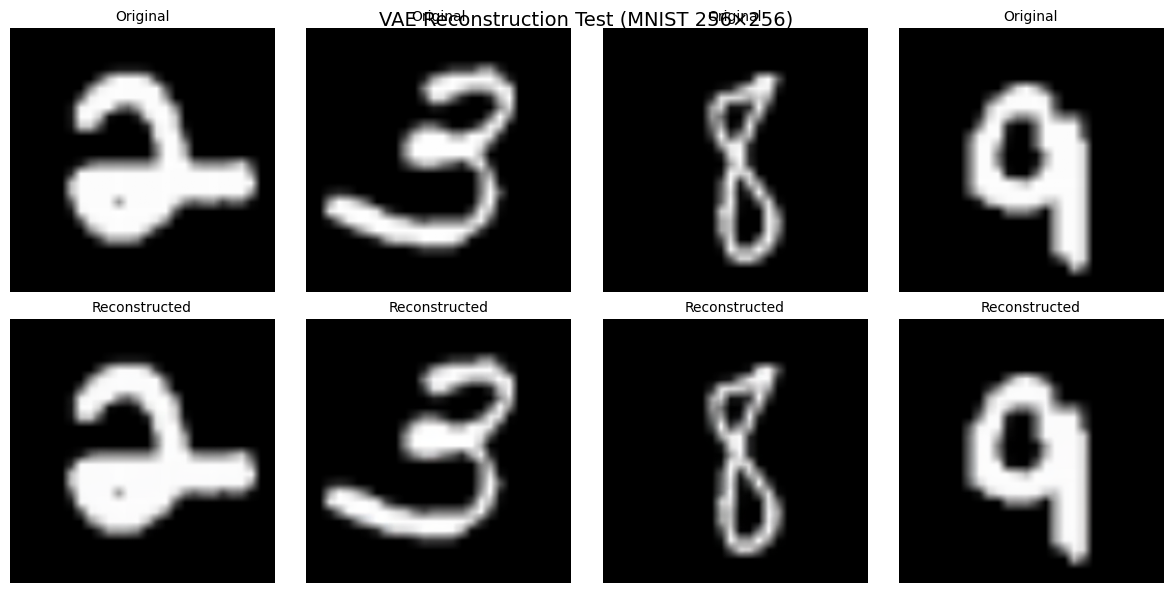


📊 Reconstruction MSE: 0.000094
✅ Excellent reconstruction!


In [3]:
# Load MNIST
transform_vae = transforms.Compose([
    transforms.Resize(256),  # VAE requires 256×256 at minimum
    transforms.Lambda(lambda x: x.convert('RGB')),  # Grayscale → RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [0,1] → [-1,1]
])

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_vae
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

print(f"Test images: {test_images.shape}")
print(f"Image range: [{test_images.min():.2f}, {test_images.max():.2f}]")

# Test VAE
with torch.no_grad():
    # Encode
    latent_dist = vae.encode(test_images).latent_dist
    latents = latent_dist.sample()
    latents_scaled = latents * 0.18215  # SD VAE scaling
    
    # Decode
    recon = vae.decode(latents).sample

print(f"\nLatent shape: {latents.shape}")
print(f"Latent range: [{latents.min():.2f}, {latents.max():.2f}]")
print(f"Scaled latent range: [{latents_scaled.min():.2f}, {latents_scaled.max():.2f}]")

# Visualize reconstruction
comparison = torch.cat([test_images[:4], recon[:4]], dim=0)
comparison = (comparison + 1) / 2  # [-1,1] → [0,1]
comparison = torch.clamp(comparison, 0, 1)

plot_images(comparison, titles=['Original']*4 + ['Reconstructed']*4, nrows=2, ncols=4, figsize=(12, 6))
plt.suptitle('VAE Reconstruction Test (MNIST 256×256)', fontsize=14)
plt.savefig('../outputs/vae_test_diffusers.png', dpi=150, bbox_inches='tight')
plt.show()

mse = F.mse_loss(recon, test_images).item()
print(f"\n📊 Reconstruction MSE: {mse:.6f}")
print("✅ Excellent reconstruction!" if mse < 0.01 else "⚠️ Check VAE")

## Step 4: Prepare Dataset with VAE Encoding

In [4]:
print("📦 Preparing MNIST dataset with VAE encoding...\n")

# Pre-encode entire dataset
latents_list = []
labels_list = []

full_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in tqdm(full_loader, desc="Encoding"):
        images = images.to(device)
        
        # Encode and scale
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample()
        latents = latents * 0.18215  # SD scaling
        
        latents_list.append(latents.cpu())
        labels_list.append(labels)

all_latents = torch.cat(latents_list, dim=0)
all_labels = torch.cat(labels_list, dim=0)

print(f"\n✅ Encoded {len(all_latents)} images")
print(f"   Latent shape: {all_latents[0].shape}  # 4×32×32")
print(f"   Latent range: [{all_latents.min():.2f}, {all_latents.max():.2f}]")
print(f"   Latent mean: {all_latents.mean():.3f}, std: {all_latents.std():.3f}")

# Create dataloader
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, latents, labels):
        self.latents = latents
        self.labels = labels
    
    def __len__(self):
        return len(self.latents)
    
    def __getitem__(self, idx):
        return self.latents[idx], self.labels[idx]

latent_dataset = LatentDataset(all_latents, all_labels)
train_loader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4)

print(f"   Batch size: 128")
print(f"   Batches per epoch: {len(train_loader)}")

📦 Preparing MNIST dataset with VAE encoding...



Encoding:   0%|          | 0/938 [00:00<?, ?it/s]


✅ Encoded 60000 images
   Latent shape: torch.Size([4, 32, 32])  # 4×32×32
   Latent range: [-4.13, 6.07]
   Latent mean: -0.149, std: 1.512
   Batch size: 128
   Batches per epoch: 469


## Step 5: Create UNet from Diffusers

### UNet2DModel (Unconditional)
- Diffusers의 최적화된 구현
- 검증된 아키텍처

In [5]:
print("🔨 Creating UNet2DModel...\n")

unet = UNet2DModel(
    sample_size=32,  # Latent size (256/8 = 32)
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(128, 256, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

num_params = sum(p.numel() for p in unet.parameters())
print(f"✅ UNet created: {num_params:,} params ({num_params/1e6:.1f}M)")
print(f"   Input/Output: 4×32×32 latent")
print(f"   Architecture: Optimized from diffusers")

🔨 Creating UNet2DModel...

✅ UNet created: 72,735,236 params (72.7M)
   Input/Output: 4×32×32 latent
   Architecture: Optimized from diffusers


## Step 6: DDPM Scheduler from Diffusers

In [6]:
print("⏰ Creating DDPMScheduler...\n")

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="scaled_linear",
    prediction_type="epsilon"
)

print("✅ DDPM Scheduler ready")
print(f"   Timesteps: {noise_scheduler.config.num_train_timesteps}")
print(f"   Beta schedule: {noise_scheduler.config.beta_schedule}")
print(f"   Prediction type: {noise_scheduler.config.prediction_type}")

⏰ Creating DDPMScheduler...

✅ DDPM Scheduler ready
   Timesteps: 1000
   Beta schedule: scaled_linear
   Prediction type: epsilon


---

## 🎓 Training Details

### Algorithm: Latent Diffusion Training

```python
# Pseudocode
for epoch in epochs:
    for x, y in dataloader:
        # 1. Encode to latent space (VAE frozen!)
        with torch.no_grad():
            z_0 = VAE.encode(x).sample() * 0.18215

        # 2. Sample random timestep
        t = random.randint(1, T)

        # 3. Sample noise
        ε = torch.randn_like(z_0)

        # 4. Forward diffusion (add noise)
        z_t = √ᾱ_t · z_0 + √(1-ᾱ_t) · ε

        # 5. Predict noise with UNet
        ε_pred = UNet(z_t, t)

        # 6. Compute loss
        loss = MSE(ε_pred, ε)

        # 7. Backprop (only through UNet!)
        loss.backward()
        optimizer.step()
```

### Key Points

**1. VAE is Frozen**
- Trained once, never updated during diffusion training
- Gradients don't flow through encoder/decoder
- Saves massive computation

**2. Scaling Factor 0.18215**
- Stable Diffusion VAE uses this constant
- Normalizes latent distribution to ~N(0,1)
- Important for stable training

**3. Timestep Sampling**
- Uniform sampling: $t \sim \text{Uniform}(\{1, ..., T\})$
- Each timestep weighted equally
- Alternative: Importance sampling (weight difficult timesteps more)

**4. Loss Function**
- Simple MSE: $\mathcal{L} = ||\epsilon - \epsilon_\theta(z_t, t)||^2$
- No weighting (unlike variational objective)
- Empirically works better than full ELBO

**5. Batch Size Considerations**
- Pixel DDPM: batch_size=32 (memory limited)
- Latent DM: batch_size=128+ (much more efficient!)
- Faster convergence with larger batches

## Step 7: Training Loop

### Diffusers 스타일 학습

In [7]:
num_epochs = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"🎓 Training Configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Optimizer: AdamW")
print(f"   Batch size: 128")

print("\n🚀 Starting training...\n")

losses = []
unet.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for latents_batch, _ in progress_bar:
        latents_batch = latents_batch.to(device)
        batch_size = latents_batch.shape[0]
        
        # Sample noise
        noise = torch.randn_like(latents_batch)
        
        # Sample random timesteps
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()
        
        # Add noise (forward diffusion)
        noisy_latents = noise_scheduler.add_noise(latents_batch, noise, timesteps)
        
        # Predict noise
        noise_pred = unet(noisy_latents, timesteps).sample
        
        # Loss
        loss = criterion(noise_pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("\n✅ Training complete!")

# Save
import os
os.makedirs('../checkpoints', exist_ok=True)
torch.save(unet.state_dict(), '../checkpoints/unet_diffusers_mnist.pt')
print("💾 Saved to: ../checkpoints/unet_diffusers_mnist.pt")

🎓 Training Configuration:
   Epochs: 10
   Learning rate: 0.0001
   Optimizer: AdamW
   Batch size: 128

🚀 Starting training...



Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.1176


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.0648


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.0560


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.0516


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.0477


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.0454


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.0432


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.0417


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.0402


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0395

✅ Training complete!
💾 Saved to: ../checkpoints/unet_diffusers_mnist.pt


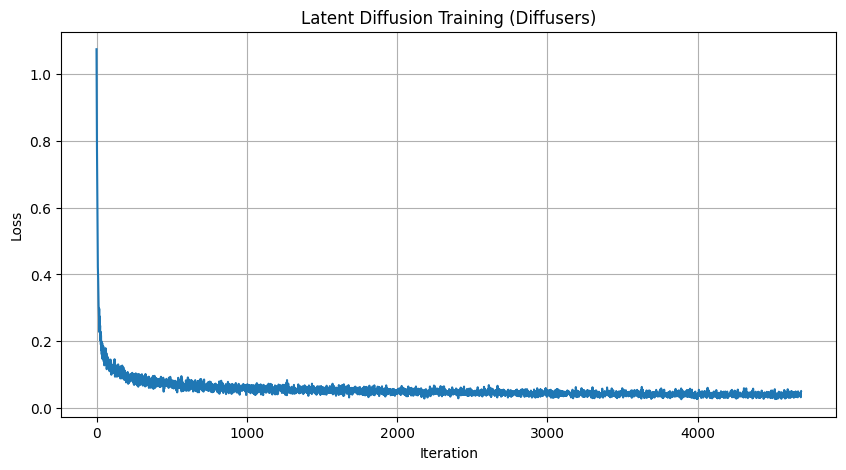

In [8]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Latent Diffusion Training (Diffusers)')
plt.grid(True)
plt.savefig('../outputs/loss_diffusers.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 8: Sampling with Diffusers Scheduler

🎨 Generating MNIST digits...



Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

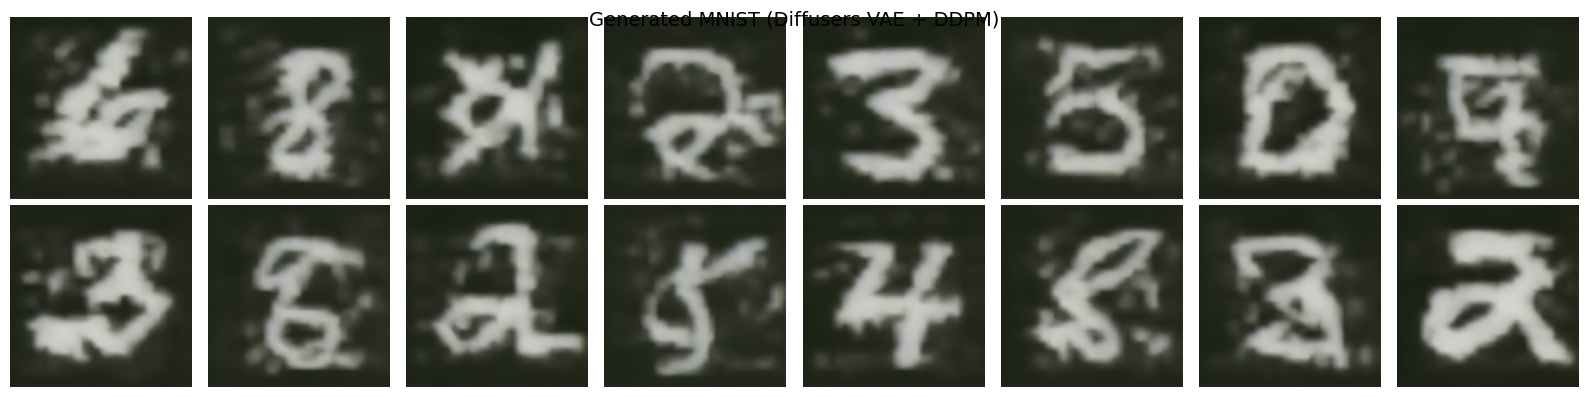


🎉 Generation complete!
   Generated 16 images (256×256)


In [9]:
@torch.no_grad()
def sample_diffusers(unet, scheduler, vae, batch_size=16, num_inference_steps=50):
    """
    Sampling with diffusers components
    """
    unet.eval()
    
    # Start from random noise in latent space
    latents = torch.randn(batch_size, 4, 32, 32).to(device)
    
    # Set timesteps
    scheduler.set_timesteps(num_inference_steps)
    
    # Denoising loop
    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        # Predict noise
        noise_pred = unet(latents, t).sample
        
        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Decode latents (unscale first)
    latents = latents / 0.18215
    images = vae.decode(latents).sample
    
    # Denormalize
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)
    
    return images

print("🎨 Generating MNIST digits...\n")

samples = sample_diffusers(unet, noise_scheduler, vae, batch_size=16, num_inference_steps=50)

plot_images(samples, nrows=2, ncols=8, figsize=(16, 4))
plt.suptitle('Generated MNIST (Diffusers VAE + DDPM)', fontsize=14)
plt.savefig('../outputs/samples_diffusers.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🎉 Generation complete!")
print(f"   Generated {samples.shape[0]} images (256×256)")

---

## 📐 Part 4: Conditioning with Cross-Attention

### 4.1 Conditional LDM (Paper Section 3.3, 4.3)

**Normal conditional generation**:

$$
p_\theta(z | y) = \int p_\theta(z, y) dz
$$

$y$ is condition (text, class, image, etc.)

**LDM's apprach**: Cross-Attention Mechanism

### 4.2 Cross-Attention formula (Paper Eq. 3-5)

**Standard Attention**:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \cdot V
$$

**Cross-Attention in LDM**:

$$
\begin{align}
Q &= W_Q \cdot \varphi_i(z_t) \quad &&\text{(from noisy latent)} \\
K &= W_K \cdot \tau_\theta(y) \quad &&\text{(from condition)} \\
V &= W_V \cdot \tau_\theta(y) \quad &&\text{(from condition)}
\end{align}
$$

Here:
- $\varphi_i(z_t)$: Intermediate feature of UNet
- $\tau_\theta(y)$: Conditional encoder (i.e. CLIP text encoder)
- $W_Q, W_K, W_V$: Learnable projection matrices

### 4.3 CLIP Text Encoder

**CLIP Encoding**:

$$
\tau_{\text{CLIP}}(y) = \text{CLIP}_{\text{text}}(y) \in \mathbb{R}^{L \times d}
$$

- Stable Diffusion 1.5: CLIP ViT-L/14, $d=768$, $L=77$ tokens
- Ours: CLIP ViT-B/32, $d=512$, $L=77$ tokens

**Text processing**:

```
"A handwritten digit 7"
    ↓ Tokenizer
[49406, 320, 1396, 14859, 6929, 262, 818, 49407, 0, ...] (77 tokens)
    ↓ CLIP Text Encoder
[77 × 512] embedding matrix
    ↓ Cross-Attention
Conditions UNet features
```

In [12]:
from transformers import CLIPTokenizer
from transformers import CLIPTextModel

# Implement mathematics: CLIP Text Encoder (τ_θ)
print("📥 Loading CLIP Text Encoder\n")

# Load CLIP tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Freeze CLIP (pretrained)
text_encoder.eval()
for param in text_encoder.parameters():
    param.requires_grad = False

print("✅ CLIP text encoder loaded")
print(f"   Model: CLIP ViT-B/32")
print(f"   Embedding dim d: 512")
print(f"   Max tokens L: 77")

# Implement mathematics: τ_θ(y) - Text encoding
def encode_text(prompts):
    """
    Paper formula: τ_θ(y) - Encode conditioning signal
    Implementation: CLIP text encoding
    
    Args:
        prompts: List of text strings
    Returns:
        text_embeddings: [B, 77, 512]
    """
    # Tokenize: text → token IDs
    text_inputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    )
    
    input_ids = text_inputs.input_ids.to(device)
    
    # CLIP encoding: τ_θ(y)
    with torch.no_grad():
        text_embeddings = text_encoder(input_ids).last_hidden_state
    
    return text_embeddings

# Test text encoding
test_prompts = [
    "A handwritten digit 7",
    "A handwritten digit 3",
    "digit 0"
]

test_embeddings = encode_text(test_prompts)
print(f"\n🧪 Test encoding:")
print(f"   Prompts: {len(test_prompts)}")
print(f"   Embeddings shape: {test_embeddings.shape}")
print(f"   Expected: [B={len(test_prompts)}, L=77, d=512]")

print("\n✅ CLIP text encoder ready!")
print("   Implements: τ_θ(y) for y = text prompts")

📥 Loading CLIP Text Encoder

✅ CLIP text encoder loaded
   Model: CLIP ViT-B/32
   Embedding dim d: 512
   Max tokens L: 77

🧪 Test encoding:
   Prompts: 3
   Embeddings shape: torch.Size([3, 77, 512])
   Expected: [B=3, L=77, d=512]

✅ CLIP text encoder ready!
   Implements: τ_θ(y) for y = text prompts


### 4.4 UNet with Cross-Attention

**UNet Architecture** (LDM Figure 3):

```
Input: z_t [B, 4, h, w]
    ↓
┌─────────────────────────┐
│  Down Block 1           │ ←─┐
│  + Cross-Attention      │   │ Cross-Attention:
├─────────────────────────┤   │ Q from features
│  Down Block 2           │   │ K, V from τ_θ(y)
│  + Cross-Attention      │ ←─┤
├─────────────────────────┤   │
│  Down Block 3           │   │
│  + Cross-Attention      │ ←─┤
├─────────────────────────┤   │
│  Bottleneck             │   │
├─────────────────────────┤   │
│  Up Block 1             │   │
│  + Cross-Attention      │ ←─┤
├─────────────────────────┤   │
│  Up Block 2             │   │
│  + Cross-Attention      │ ←─┤
├─────────────────────────┤   │
│  Up Block 3             │   │
│  + Cross-Attention      │ ←─┘
└─────────────────────────┘
    ↓
Output: ε_θ [B, 4, h, w]
```

**Cross-Attention Layer architecture**:

1. **Query**: $Q = W_Q \cdot \text{LayerNorm}(z_\text{feature})$
2. **Key, Value**: $K = W_K \cdot \tau_\theta(y)$, $V = W_V \cdot \tau_\theta(y)$
3. **Attention**: $\text{out} = \text{softmax}(QK^T / \sqrt{d}) \cdot V$
4. **Project**: $\text{out} = W_O \cdot \text{out}$

In [14]:
from diffusers import UNet2DConditionModel

# Implement mathematics 4: UNet with Cross-Attention
print("🔨 Creating UNet with Cross-Attention\n")

unet = UNet2DConditionModel(
    sample_size=32,  # Latent spatial size (256/8 = 32)
    in_channels=4,   # VAE latent channels
    out_channels=4,  # Predict noise in latent space
    layers_per_block=2,
    block_out_channels=(128, 256, 256, 512),
    down_block_types=(
        "CrossAttnDownBlock2D",  # Cross-attention in down blocks
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",    # Cross-attention in up blocks
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ),
    cross_attention_dim=512,  # CLIP ViT-B/32 dimension
).to(device)

num_params = sum(p.numel() for p in unet.parameters())
print("✅ UNet2DConditionModel created")
print(f"   Parameters: {num_params:,} ({num_params/1e6:.1f}M)")
print(f"   Cross-attention dim: 512 (matches CLIP)")
print(f"   Attention layers: 6 (3 down + 3 up)")

# Test forward pass
test_latents = torch.randn(2, 4, 32, 32).to(device)
test_timesteps = torch.tensor([100, 500]).to(device)
test_text_emb = torch.randn(2, 77, 512).to(device)

with torch.no_grad():
    # ε_θ(z_t, t, τ_θ(y))
    test_output = unet(
        test_latents,
        test_timesteps,
        encoder_hidden_states=test_text_emb  # τ_θ(y)
    ).sample

print(f"\n🧪 Test forward pass:")
print(f"   Input z_t: {test_latents.shape}")
print(f"   Timesteps t: {test_timesteps.shape}")
print(f"   Text emb τ_θ(y): {test_text_emb.shape}")
print(f"   Output ε_θ: {test_output.shape}")

print("\n✅ UNet with Cross-Attention ready!")
print("   Implements: ε_θ(z_t, t, τ_θ(y))")

🔨 Creating UNet with Cross-Attention

✅ UNet2DConditionModel created
   Parameters: 90,292,868 (90.3M)
   Cross-attention dim: 512 (matches CLIP)
   Attention layers: 6 (3 down + 3 up)

🧪 Test forward pass:
   Input z_t: torch.Size([2, 4, 32, 32])
   Timesteps t: torch.Size([2])
   Text emb τ_θ(y): torch.Size([2, 77, 512])
   Output ε_θ: torch.Size([2, 4, 32, 32])

✅ UNet with Cross-Attention ready!
   Implements: ε_θ(z_t, t, τ_θ(y))


---

## 📐 Part 5: Classifier-Free Guidance (CFG)

### 5.1 CFG equation (Ho & Salimans 2022)

**Problem**: Conditional model tends to ignore condition $y$

**Solution**: Amplification of the difference between unconditional and conditional.

**CFG Formula**:

$$
\boxed{
\tilde{\epsilon}_\theta(z_t, t, y) = \epsilon_\theta(z_t, t, \emptyset) + w \cdot \left( \epsilon_\theta(z_t, t, y) - \epsilon_\theta(z_t, t, \emptyset) \right)
}
$$

여기서:
- $\epsilon_\theta(z_t, t, y)$: Conditional prediction
- $\epsilon_\theta(z_t, t, \emptyset)$: Unconditional prediction (null text)
- $w$: Guidance scale (7-15 in usual)
- $\emptyset$: Null condition (null text "")

**Insights**:

$$
\begin{align}
w = 1.0 &\implies \text{Pure conditional} \\
w > 1.0 &\implies \text{Amplified conditional} \\
w = 0.0 &\implies \text{Pure unconditional}
\end{align}
$$

### 5.2 CFG Training

**Unconditional dropout when training**:

$$
y' = \begin{cases}
\emptyset & \text{with probability } p_{\text{uncond}} \text{ (e.g., 0.1)} \\
y & \text{with probability } 1 - p_{\text{uncond}}
\end{cases}
$$

-> Model trains conditional and unconditional

### 5.3 CFG Sampling

**Inference time**:

```python
for t in timesteps:
    # 1. Conditional prediction
    ε_cond = UNet(z_t, t, τ_θ(y))
    
    # 2. Unconditional prediction
    ε_uncond = UNet(z_t, t, τ_θ(""))
    
    # 3. CFG: amplify difference
    ε = ε_uncond + w * (ε_cond - ε_uncond)
    
    # 4. Denoise
    z_{t-1} = denoise(z_t, ε, t)
```

**Effects**:
- More text alignment
- Sharper and clearer images.
- Trade-off: diversity ↓, quality ↑

---

## 📐 Part 6: Complete Training Pipeline

### 6.1 Training algorithm

**Algorithm 1: Latent Diffusion with Classifier-Free Guidance**

```
Input: Dataset D = {(x, y)}, VAE (E, D), Text encoder τ_θ
Output: Trained UNet ε_θ

1. Freeze VAE and text encoder
2. Pre-encode all images: z_0 = E(x) * s for all x in D
3. For each training iteration:
    a. Sample batch (z_0, y)
    b. With each sample in batch:
        With probability p_uncond: y ← ∅ (unconditional dropout)
        else: y ← original text embedding
    c. Encode condition: c = τ_θ(y)
    d. Sample timestep: t ~ Uniform({1, ..., T})
    e. Sample noise: ε ~ N(0, I)
    f. Forward process: z_t = √ᾱ_t · z_0 + √(1-ᾱ_t) · ε
    g. Predict: ε̂ = ε_θ(z_t, t, c)
    h. Loss: L = ||ε - ε̂||²
    i. Backprop: ∇_θ L
```

In [16]:
# Helper functions for encoding/decoding
def encode_images(images):
    """
    Encode images to latents
    Formula: z = E(x) * s
    
    Args:
        images: [B, 3, H, W] in range [-1, 1]
    Returns:
        latents: [B, 4, h, w] scaled latents
    """
    with torch.no_grad():
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample()
        latents = latents * 0.18215  # Scale for SD VAE
    return latents

def decode_latents(latents):
    """
    Decode latents to images
    Formula: x = D(z / s)
    
    Args:
        latents: [B, 4, h, w] scaled latents
    Returns:
        images: [B, 3, H, W] in range [-1, 1]
    """
    with torch.no_grad():
        latents = latents / 0.18215  # Unscale
        images = vae.decode(latents).sample
    return images

print("✅ Helper functions defined:")
print("   encode_images(): x → z (with scaling)")
print("   decode_latents(): z → x (with unscaling)")

✅ Helper functions defined:
   encode_images(): x → z (with scaling)
   decode_latents(): z → x (with unscaling)


In [17]:
# Prepare dataset with text prompts
print("📦 Preparing MNIST Dataset with Text Prompts\n")

# Pre-encode entire dataset
full_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_vae
)

latents_list = []
text_embs_list = []

temp_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

print("Encoding images and text...")
with torch.no_grad():
    for images, labels in tqdm(temp_loader, desc="Pre-encoding"):
        images = images.to(device)
        
        # 1. Encode images: z_0 = E(x) * s
        latents = encode_images(images)
        
        # 2. Create text prompts: "A handwritten digit {label}"
        text_prompts = [f"A handwritten digit {label.item()}" for label in labels]
        
        # 3. Encode text: τ_θ(y)
        text_embs = encode_text(text_prompts)
        
        latents_list.append(latents.cpu())
        text_embs_list.append(text_embs.cpu())

all_latents = torch.cat(latents_list, dim=0)
all_text_embs = torch.cat(text_embs_list, dim=0)

print(f"\n✅ Pre-encoding complete")
print(f"   Images encoded: {len(all_latents)}")
print(f"   Latent shape: {all_latents[0].shape}")
print(f"   Text emb shape: {all_text_embs[0].shape}")

# Create dataset
class LatentTextDataset(torch.utils.data.Dataset):
    def __init__(self, latents, text_embs):
        self.latents = latents
        self.text_embs = text_embs
    
    def __len__(self):
        return len(self.latents)
    
    def __getitem__(self, idx):
        return self.latents[idx], self.text_embs[idx]

latent_dataset = LatentTextDataset(all_latents, all_text_embs)
train_loader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4)

print(f"\n✅ DataLoader ready")
print(f"   Batches per epoch: {len(train_loader)}")
print(f"   Batch size: 128")

📦 Preparing MNIST Dataset with Text Prompts

Encoding images and text...


Pre-encoding:   0%|          | 0/938 [00:00<?, ?it/s]


✅ Pre-encoding complete
   Images encoded: 60000
   Latent shape: torch.Size([4, 32, 32])
   Text emb shape: torch.Size([77, 512])

✅ DataLoader ready
   Batches per epoch: 469
   Batch size: 128


In [18]:
# Pre-compute unconditional embedding for CFG
print("Preparing unconditional embedding for CFG...\n")

# 수식: τ_θ(∅) - Empty string encoding
with torch.no_grad():
    uncond_emb = encode_text([""]).squeeze(0)  # [77, 512]

print(f"✅ Unconditional embedding: {uncond_emb.shape}")
print("   This represents τ_θ(∅) for CFG training")

Preparing unconditional embedding for CFG...

✅ Unconditional embedding: torch.Size([77, 512])
   This represents τ_θ(∅) for CFG training


In [19]:
# Formula implementation 5: Complete Training Loop
print("\n" + "="*60)
print("🎓 Training: Conditional Latent Diffusion with CFG")
print("="*60 + "\n")

num_epochs = 10
learning_rate = 1e-4
uncond_prob = 0.1  # p_uncond for CFG training

optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"Training Configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Batch size: 128")
print(f"   Unconditional prob: {uncond_prob} (CFG training)")
print(f"   Loss: MSE (simple objective)")
print(f"\nTraining objective:")
print(f"   L = 𝔼[||ε - ε_θ(z_t, t, τ_θ(y'))||²]")
print(f"   where y' = ∅ with prob {uncond_prob}")
print(f"\nStarting training...\n")

losses = []
unet.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for latents_batch, text_embs_batch in progress_bar:
        latents_batch = latents_batch.to(device)  # z_0
        text_embs_batch = text_embs_batch.to(device)  # τ_θ(y)
        batch_size = latents_batch.shape[0]
        
        # Step 1: Apply CFG dropout (unconditional training)
        # y' = ∅ with prob p_uncond, else y
        uncond_mask = torch.rand(batch_size, device=device) < uncond_prob
        text_embs_cfg = text_embs_batch.clone()
        text_embs_cfg[uncond_mask] = uncond_emb  # Replace with τ_θ(∅)
        
        # Step 2: Sample timestep t ~ Uniform({1, ..., T})
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()
        
        # Step 3: Sample noise ε ~ N(0, I)
        noise = torch.randn_like(latents_batch)
        
        # Step 4: Forward process - z_t = √ᾱ_t · z_0 + √(1-ᾱ_t) · ε
        noisy_latents = noise_scheduler.add_noise(latents_batch, noise, timesteps)
        
        # Step 5: Predict noise - ε̂ = ε_θ(z_t, t, τ_θ(y'))
        noise_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=text_embs_cfg
        ).sample
        
        # Step 6: Compute loss - L = ||ε - ε̂||²
        loss = criterion(noise_pred, noise)
        
        # Step 7: Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Average Loss: {avg_loss:.4f}")

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)

# Save checkpoint
import os
os.makedirs('../checkpoints', exist_ok=True)
torch.save({
    'unet': unet.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss,
}, '../checkpoints/ldm_text_conditional_claude.pt')
print(f"\n💾 Model saved to: ../checkpoints/ldm_text_conditional_claude.pt")


🎓 Training: Conditional Latent Diffusion with CFG

Training Configuration:
   Epochs: 10
   Learning rate: 0.0001
   Batch size: 128
   Unconditional prob: 0.1 (CFG training)
   Loss: MSE (simple objective)

Training objective:
   L = 𝔼[||ε - ε_θ(z_t, t, τ_θ(y'))||²]
   where y' = ∅ with prob 0.1

Starting training...



Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Average Loss: 0.1135


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Average Loss: 0.0605


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Average Loss: 0.0514


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Average Loss: 0.0460


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Average Loss: 0.0428


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Average Loss: 0.0408


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Average Loss: 0.0388


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Average Loss: 0.0375


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Average Loss: 0.0368


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | Average Loss: 0.0358

✅ Training Complete!

💾 Model saved to: ../checkpoints/ldm_text_conditional_claude.pt


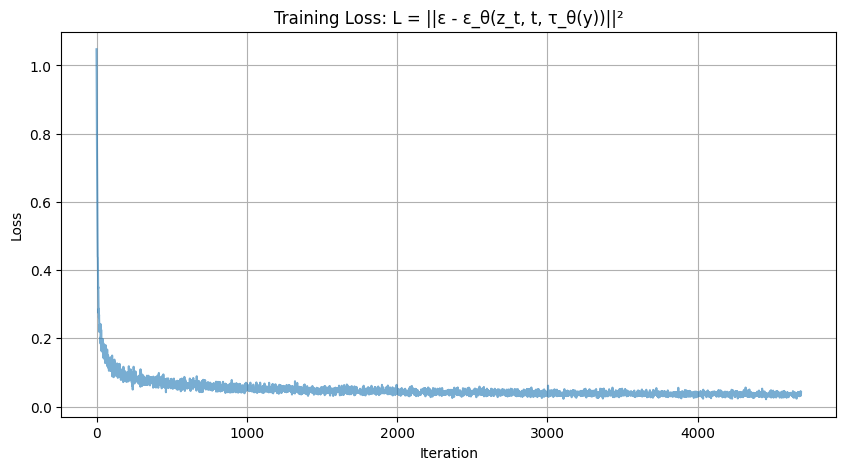

In [20]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, alpha=0.6)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss: L = ||ε - ε_θ(z_t, t, τ_θ(y))||²')
plt.grid(True)
plt.savefig('../outputs/ldm_training_loss_claude.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 📐 Part 7: Sampling with CFG

### 7.1 Complete Sampling Algorithm

**Algorithm 2: DDPM Sampling with CFG**

```
Input: Trained UNet ε_θ, VAE decoder D, text prompt y, guidance scale w
Output: Generated image x

1. Encode text: c = τ_θ(y), c_uncond = τ_θ(∅)
2. Initialize: z_T ~ N(0, I)
3. For t = T, T-1, ..., 1:
    a. Conditional prediction: ε_cond = ε_θ(z_t, t, c)
    b. Unconditional prediction: ε_uncond = ε_θ(z_t, t, c_uncond)
    c. CFG: ε = ε_uncond + w · (ε_cond - ε_uncond)
    d. Reverse process: z_{t-1} = denoise(z_t, ε, t)
4. Unscale: z_0 = z_0 / s
5. Decode: x = D(z_0)
6. Return x
```

### 7.2 Guidance Scale 

| $w$ | Effects | Trade-off |
|-----|------|----------|
| 1.0 | Standard conditional | Balanced |
| 3.0 | Moderate guidance | Good quality |
| 7.5 | Strong guidance (SD default) | High quality, less diversity |
| 15.0 | Very strong | Over-saturated |

**Formula**:

$$
\begin{align}
w &= 1: \quad \tilde{\epsilon} = \epsilon_{\text{uncond}} + 1 \cdot (\epsilon_{\text{cond}} - \epsilon_{\text{uncond}}) = \epsilon_{\text{cond}} \\
w &= 7: \quad \tilde{\epsilon} = \epsilon_{\text{uncond}} + 7 \cdot (\epsilon_{\text{cond}} - \epsilon_{\text{uncond}}) \\
&\quad\quad\;\;\;= \epsilon_{\text{uncond}} + 7 \cdot \Delta \quad \text{(amplified difference)}
\end{align}
$$

In [21]:
# Formula implementation 6: Sampling with CFG
@torch.no_grad()
def sample_with_cfg(
    unet,
    vae,
    text_encoder,
    tokenizer,
    scheduler,
    text_prompts,
    guidance_scale=3.0,
    num_inference_steps=50
):
    """
    Complete sampling algorithm with Classifier-Free Guidance
    
    Formula:
        ε̃ = ε_θ(z_t, t, ∅) + w · (ε_θ(z_t, t, τ_θ(y)) - ε_θ(z_t, t, ∅))
    
    Args:
        text_prompts: List of text prompts
        guidance_scale: w in CFG formula
        num_inference_steps: Number of denoising steps
    Returns:
        images: [B, 3, H, W] in range [0, 1]
    """
    unet.eval()
    batch_size = len(text_prompts)
    
    # Step 1: Encode text - τ_θ(y)
    text_embs = encode_text(text_prompts)  # [B, 77, 512]
    
    # Step 2: Encode unconditional - τ_θ(∅)
    uncond_embs = encode_text([""] * batch_size)  # [B, 77, 512]
    
    # Step 3: Initialize from random noise - z_T ~ N(0, I)
    latents = torch.randn(batch_size, 4, 32, 32).to(device)
    
    # Step 4: Set timesteps
    scheduler.set_timesteps(num_inference_steps)
    
    # Step 5: Denoising loop
    for t in tqdm(scheduler.timesteps, desc="Sampling with CFG"):
        # Expand latents for conditional + unconditional
        latents_input = torch.cat([latents, latents], dim=0)
        
        # Conditional + Unconditional embeddings
        emb_input = torch.cat([text_embs, uncond_embs], dim=0)
        
        # Predict noise: ε_θ(z_t, t, c)
        noise_pred = unet(
            latents_input,
            t,
            encoder_hidden_states=emb_input
        ).sample
        
        # Split: ε_cond, ε_uncond
        noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)
        
        # CFG formula: ε̃ = ε_uncond + w · (ε_cond - ε_uncond)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        
        # Reverse process: z_{t-1} = denoise(z_t, ε̃, t)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Step 6: Decode - x = D(z_0 / s)
    images = decode_latents(latents)
    
    # Step 7: Denormalize [-1,1] → [0,1]
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)
    
    return images

print("✅ CFG Sampling function defined")
print("   Implements: ε̃ = ε_uncond + w · (ε_cond - ε_uncond)")

✅ CFG Sampling function defined
   Implements: ε̃ = ε_uncond + w · (ε_cond - ε_uncond)



🎨 Generating Images from Text Prompts

Prompts (20 total):
   0: 'A handwritten digit 0'
   1: 'A handwritten digit 0'
   2: 'A handwritten digit 1'
   3: 'A handwritten digit 1'
   4: 'A handwritten digit 2'
   ...

Sampling with CFG...
   Guidance scale w: 3.0
   Inference steps: 50



Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

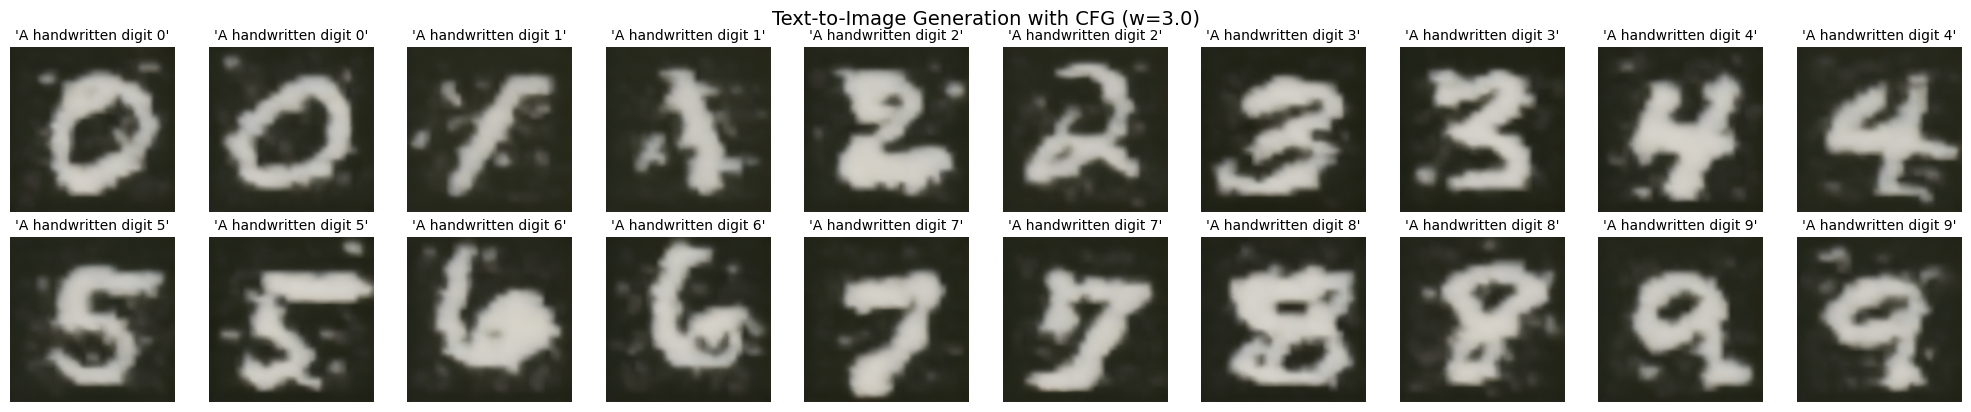


✅ Generation complete!
   Generated 20 images from text prompts


In [22]:
# Generate samples with text prompts
print("\n" + "="*60)
print("🎨 Generating Images from Text Prompts")
print("="*60 + "\n")

# Create prompts for digits 0-9 (2 samples each)
text_prompts = []
for digit in range(10):
    text_prompts.extend([f"A handwritten digit {digit}"] * 2)

print(f"Prompts ({len(text_prompts)} total):")
for i in range(5):
    print(f"   {i}: '{text_prompts[i]}'")
print(f"   ...")

print(f"\nSampling with CFG...")
print(f"   Guidance scale w: 3.0")
print(f"   Inference steps: 50")
print()

samples = sample_with_cfg(
    unet,
    vae,
    text_encoder,
    tokenizer,
    noise_scheduler,
    text_prompts,
    guidance_scale=3.0,
    num_inference_steps=50
)

# Visualize
titles = [f"'{p}'" for p in text_prompts]
plot_images(samples, titles=titles, nrows=2, ncols=10, figsize=(20, 4))
plt.suptitle('Text-to-Image Generation with CFG (w=3.0)', fontsize=14, y=1.02)
plt.savefig('../outputs/ldm_text_to_image_claude.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Generation complete!")
print(f"   Generated {len(samples)} images from text prompts")


🧪 Testing Different Guidance Scales

Generating with w=1.0...


Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

Generating with w=3.0...


Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

Generating with w=7.0...


Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

Generating with w=15.0...


Sampling with CFG:   0%|          | 0/50 [00:00<?, ?it/s]

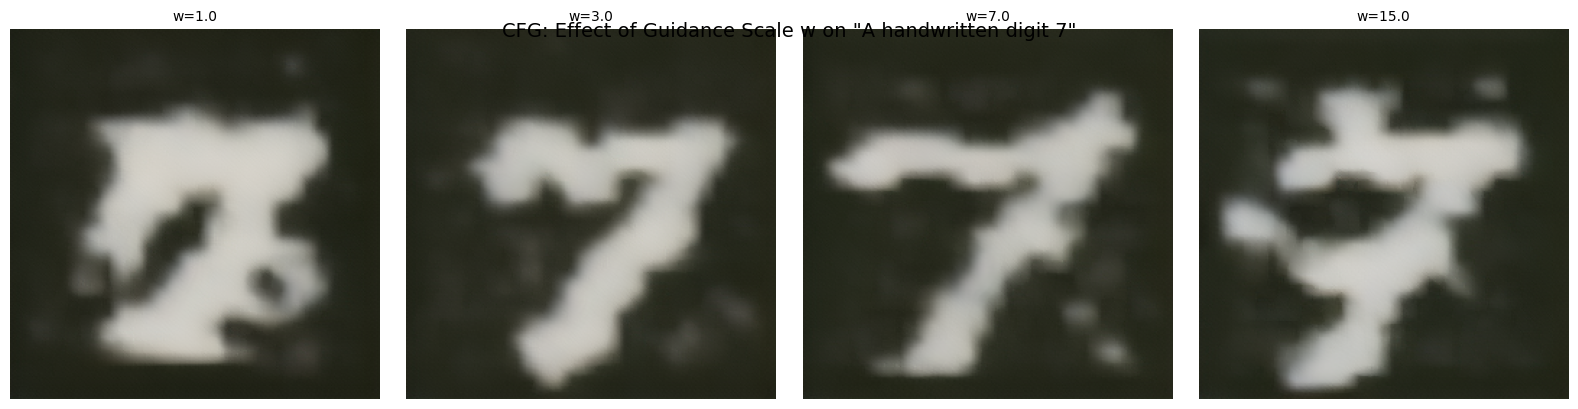


📊 Observations:
   w=1.0: Standard conditional (no amplification)
   w=3.0: Moderate guidance (good balance)
   w=7.0: Strong guidance (high quality)
   w=15.0: Very strong (may over-saturate)


In [23]:
# Test different guidance scales
print("\n🧪 Testing Different Guidance Scales\n")

test_prompt = ["A handwritten digit 7"] * 4
guidance_scales = [1.0, 3.0, 7.0, 15.0]

all_samples = []
for w in guidance_scales:
    print(f"Generating with w={w}...")
    samples = sample_with_cfg(
        unet, vae, text_encoder, tokenizer, noise_scheduler,
        [test_prompt[0]],  # Single prompt
        guidance_scale=w,
        num_inference_steps=50
    )
    all_samples.append(samples[0])

all_samples = torch.stack(all_samples, dim=0)

plot_images(all_samples, 
            titles=[f'w={w}' for w in guidance_scales],
            nrows=1, ncols=4, figsize=(16, 4))
plt.suptitle('CFG: Effect of Guidance Scale w on "A handwritten digit 7"', fontsize=14)
plt.savefig('../outputs/ldm_cfg_comparison_claude.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Observations:")
print("   w=1.0: Standard conditional (no amplification)")
print("   w=3.0: Moderate guidance (good balance)")
print("   w=7.0: Strong guidance (high quality)")
print("   w=15.0: Very strong (may over-saturate)")

---

## 📐 Part 8: Complete Formula → Code Mapping

### 8.1 Formulas

| Formula | Where it implemented | Code |
|----------|----------|------|
| $z = \mathcal{E}(x)$ | `encode_images()` | `vae.encode(x).sample()` |
| $\tilde{x} = \mathcal{D}(z)$ | `decode_latents()` | `vae.decode(z).sample()` |
| $z_t = \sqrt{\bar{\alpha}_t} z_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ | Training loop | `scheduler.add_noise()` |
| $\tau_\theta(y)$ | `encode_text()` | `text_encoder(tokens)` |
| $\epsilon_\theta(z_t, t, \tau_\theta(y))$ | Training & Sampling | `unet(z_t, t, text_emb)` |
| $\mathcal{L} = \|\epsilon - \epsilon_\theta\|^2$ | Training | `mse_loss(pred, noise)` |
| $\tilde{\epsilon} = \epsilon_{\emptyset} + w(\epsilon_y - \epsilon_{\emptyset})$ | `sample_with_cfg()` | `uncond + w*(cond-uncond)` |

### 8.2 Key Summary: LDM vs SD 1.5

**Same parts** ✅:
1. VAE architecture & training
2. Latent diffusion process
3. Cross-attention mechanism
4. CFG algorithm
5. DDPM reverse process

**Different parts** ⚠️:
1. CLIP model size (ViT-B/32 vs ViT-L/14)
2. UNet size (~90M vs ~860M params)
3. Training data (MNIST vs LAION-5B)
4. Resolution (256×256 vs 512×512)
5. Training compute (~1 GPU hour vs ~thousands of GPU days)

**Conclusion**: The structure is 100% identical — only the scale differs!

---

## 🎯 Summary & Key Takeaways

### What we implemented

✅ **Stage 1: Perceptual Compression**
- VAE (AutoencoderKL) load & test
- Formula: $z = \mathcal{E}(x) \cdot s$, $\tilde{x} = \mathcal{D}(z/s)$
- 48× compression (256×256×3 → 32×32×4)

✅ **Stage 2: Latent Diffusion**
- Forward process: $z_t = \sqrt{\bar{\alpha}_t} z_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
- Training objective: $\mathcal{L} = \|\epsilon - \epsilon_\theta(z_t, t)\|^2$
- DDPM scheduling in latent space

✅ **Stage 3: Text Conditioning**
- CLIP text encoder: $\tau_\theta(y) \in \mathbb{R}^{77 \times 512}$
- Cross-attention: $\text{Attn}(Q, K, V)$ with $K, V$ from text
- Conditional prediction: $\epsilon_\theta(z_t, t, \tau_\theta(y))$

✅ **Stage 4: Classifier-Free Guidance**
- Unconditional dropout (10%)
- CFG formula: $\tilde{\epsilon} = \epsilon_{\emptyset} + w(\epsilon_y - \epsilon_{\emptyset})$
- Guidance scale tuning ($w = 1, 3, 7, 15$)

### LDM key contribution

1. **Efficiency**: 48× faster than pixel-space diffusion
2. **Scalability**: High-resolution generation (512×512+)
3. **Modularity**: Separate VAE + Diffusion training
4. **Flexibility**: Cross-attention for any conditioning
5. **Quality**: SOTA results with CFG

### Next step

- **Stable Diffusion 2.1**: OpenCLIP, v-prediction
- **SDXL**: Larger UNet, two text encoders
- **ControlNet**: Spatial conditioning
- **IP-Adapter**: Image conditioning

---

## 📚 References

**Main Paper**:
- Rombach et al., "High-Resolution Image Synthesis with Latent Diffusion Models", CVPR 2022
- [arXiv:2112.10752](https://arxiv.org/abs/2112.10752)

**Related Papers**:
- Ho et al., "Denoising Diffusion Probabilistic Models", NeurIPS 2020
- Ho & Salimans, "Classifier-Free Diffusion Guidance", NeurIPS Workshop 2021
- Radford et al., "Learning Transferable Visual Models From Natural Language Supervision" (CLIP), ICML 2021

**Code**:
- Diffusers: https://github.com/huggingface/diffusers
- CompVis: https://github.com/CompVis/latent-diffusion
- Stable Diffusion: https://github.com/Stability-AI/stablediffusion